# 棋子检测

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

定义训练、测试数据集路径    模型的保存路径

In [3]:
train_path = "C:/Users/王欣哲/Desktop/codes/人工智能基础/问题1 棋盘识别/pic_DB/train"
test_path = "C:/Users/王欣哲/Desktop/codes/人工智能基础/问题1 棋盘识别/pic_DB/test"

定义执行器，使用GPU运算

In [4]:
gpu_options = tf.GPUOptions(allow_growth=True)
gpu_options =tf.GPUOptions(per_process_gpu_memory_fraction=0.8,allow_growth=True) ##每个gpu占用0.8																				的显存
config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True,log_device_placement=False)
sess=tf.Session(config=config)##如果电脑有多个GPU，tensorflow默认全部使用。如果想只使用部分GPU，可以设置CUDA_VISIBLE_DEVICES。

加载训练集、测试集标签 定义图片加载函数

In [5]:
# 加载 训练集 标签
with open(train_path + "/label.csv") as f:
    train_label = np.loadtxt(f,delimiter=',') 
# 加载 测试集 标签
with open(test_path + "/label.csv") as f:
    test_label = np.loadtxt(f,delimiter=',') 

In [6]:
def get_train_batch(batch_size):
    """获取训练的batch"""
    idx = np.random.randint(1,len(train_label),size=batch_size)# 要抽取的图片数
    # 加载图片
    _label = np.zeros([batch_size,225,3],dtype = np.float32)
    _img = []
    for i in range(0,batch_size):
        for j in range(0,225):
            _label[i,j,int(train_label[idx[i],j])] = 0.99
        data_img= Image.open(train_path + "/" +str(idx[i])+".jpg")
        #图片
        _img.append((np.array(data_img)/255.0*0.99+0.01).reshape(96*96))
    _img = np.asfarray(_img)
    return _img,_label

def get_test_batch(batch_size):
    """获取训练的batch"""
    idx = np.random.randint(1,len(test_label),size=batch_size)# 要抽取的图片数
    # 加载图片
    _label = np.zeros([batch_size,225,3],dtype = np.float32)
    _img = []
    for i in range(0,batch_size):
        for j in range(0,225):
            _label[i,j,int(test_label[idx[i],j])] = 0.99
        data_img= Image.open(test_path + "/" +str(idx[i])+".jpg")
        #图片
        _img.append((np.array(data_img)/255.0*0.99+0.01).reshape(96*96))
    _img = np.asfarray(_img)
    return _img,_label

##### 定义卷积函数、神经网络
此处定义了两个卷积神经网络，使用第二个网络的识别效果更好

In [7]:
def conv2d(x, w):
    """定义卷积函数"""
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2_2(x):
    """定义2*2最大池化层"""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [10]:
##########################
#     精简卷积神经网络   #
##########################
# acc=0.99935
# 效果没有后面的网络好
xs = tf.placeholder(tf.float32,shape=(None,96*96),name = "xs")
ys = tf.placeholder(tf.float32,shape=(None,15*15,3),name = "ys")
keep_prob = tf.placeholder(tf.float32,name = "keep_prob")

y0 = tf.reshape(xs,[-1,96,96,1])
# 第一层 卷积
w1 = tf.Variable(tf.truncated_normal(shape=[3,3,1,8], stddev=0.1))
b1 = tf.Variable(tf.constant(0.1,shape=[8]))
h1 =tf.nn.relu(conv2d(y0, w1) + b1)
y1 = max_pool_2_2(h1)

# 第二层 卷积
w2 = tf.Variable(tf.truncated_normal(shape=[3,3,8,16], stddev=0.1))
b2 = tf.Variable(tf.constant(0.1,shape=[1, 16]))
h2 =tf.nn.relu(conv2d(y1, w2) + b2)
y2 = max_pool_2_2(h2)

# 第三层 卷积
w3 = tf.Variable(tf.truncated_normal(shape=[3,3,16,32], stddev=0.1))
b3 = tf.Variable(tf.constant(0.1,shape=[1, 32]))
h3 =tf.nn.relu(conv2d(y2, w3) + b3)
y3 = max_pool_2_2(h3)

# 第四层 全连接
w4 = tf.Variable(tf.truncated_normal(shape=[12*12*32, 1024],stddev=0.1))
b4 = tf.Variable(tf.constant(0.1,shape=[1, 1024]))
h4 = tf.reshape(y3,[-1,12*12*32])
y4 = tf.nn.sigmoid(tf.matmul(h4, w4) + b4)

h_y4_drop = tf.nn.dropout(y4,keep_prob)#防止过拟合

# 第五层 输出层
w5= tf.Variable(tf.truncated_normal(shape=[1024, 15*15*3],stddev=0.1))
b5 = tf.Variable(tf.constant(0.1,shape=[1, 15*15*3]))
y5 = tf.matmul(h_y4_drop,w5)+b5

# Softmax
y =tf.nn.softmax(tf.reshape(y5,[-1,15*15,3]),name="y")

In [8]:
######################
#     卷积神经网络   #
#####################
# acc=1
xs = tf.placeholder(tf.float32,shape=(None,96*96),name = "xs")
ys = tf.placeholder(tf.float32,shape=(None,15*15,3),name = "ys")
keep_prob = tf.placeholder(tf.float32,name = "keep_prob")
# ylab = tf.placeholder(tf.int64,shape=(None,15*15))

y0 = tf.reshape(xs,[-1,96,96,1])
# 第一层 卷积
w1 = tf.Variable(tf.truncated_normal(shape=[3,3,1,8], stddev=0.1))
b1 = tf.Variable(tf.constant(0.1,shape=[8]))
h1 =tf.nn.relu(conv2d(y0, w1) + b1)
y1 = max_pool_2_2(h1)

# 第二层 卷积
w2 = tf.Variable(tf.truncated_normal(shape=[3,3,8,16], stddev=0.1))
b2 = tf.Variable(tf.constant(0.1,shape=[1, 16]))
h2 =tf.nn.relu(conv2d(y1, w2) + b2)
y2 = max_pool_2_2(h2)

# 第三层 全连接
w3 = tf.Variable(tf.truncated_normal(shape=[24*24*16, 15*15*3],stddev=0.1))
b3 = tf.Variable(tf.constant(0.1,shape=[1, 15*15*3]))
h3 = tf.reshape(y2,[-1,24*24*16])
y3 = tf.nn.sigmoid(tf.matmul(h3, w3) + b3)

# Softmax
y =tf.nn.softmax(tf.reshape(y3,[-1,15*15,3]),name = "y")

定义损失函数、优化函数、优化器

In [9]:
# 损失函数
cross_entropy = -tf.reduce_sum(ys*tf.log(y),reduction_indices=[1,2])
#cross_entropy = -tf.reduce_sum(ys*tf.log(y))
loss = tf.reduce_mean(cross_entropy)
#loss = tf.reduce_sum(tf.square(ys - y))
# 正确率
correct = tf.equal(tf.argmax(y,2),tf.argmax(ys,2))
acc = tf.reduce_mean(tf.cast(correct,tf.float32))

# 优化函数
train = tf.train.AdamOptimizer(1e-3).minimize(loss)

In [10]:
# 变量初始化
init = tf.global_variables_initializer()
sess.run(init)

In [11]:
batch = get_train_batch(1)

print(batch[0].shape)
#print(sess.run(y,feed_dict={xs:batch[0],ys:batch[1],keep_prob:0.5}))
print(sess.run(acc,feed_dict={xs:batch[0],ys:batch[1],keep_prob:1.0}))
print(sess.run(loss,feed_dict={xs:batch[0],ys:batch[1],keep_prob:1.0}))

(1, 9216)
0.3288889
247.98145


开始训练

In [12]:
res_train_loss = []
res_train_acc = []

res_test_loss = []
res_test_acc = []

In [14]:
# 训练
BATCH_SIZE=256
batch_test = get_test_batch(1000)
for i in range(3000):
    # 生成一个Batch 的数据
    batch = get_train_batch(BATCH_SIZE)
    # 训练
    sess.run(train, feed_dict={xs:batch[0], ys:batch[1],keep_prob:1.0})
    
    if i%5==0:
        l = sess.run(loss, feed_dict={xs:batch[0], ys: batch[1],keep_prob:1.0})
        ac = sess.run(acc,feed_dict={xs:batch[0], ys: batch[1],keep_prob:1.0})
        res_train_loss.append(l)
        res_train_acc.append(ac)
        print("  time %d loss:%.5f  acc:%f" %(i,l,ac))
        
    if i%50==0:
        
        l = sess.run(loss, feed_dict={xs:batch_test[0], ys: batch_test[1],keep_prob:1.0})
        ac = sess.run(acc,feed_dict={xs:batch_test[0], ys: batch_test[1],keep_prob:1.0})
        res_test_loss.append(l)
        res_test_acc.append(ac)
        print("test  time:%d  loss:%.5f  acc:%f" %(i,l,ac))

  time 0 loss:234.03326  acc:0.486059
test  time:0  loss:237.86504  acc:0.454867
  time 5 loss:232.14783  acc:0.498403
  time 10 loss:224.81958  acc:0.523212
  time 15 loss:215.79324  acc:0.556181
  time 20 loss:214.11888  acc:0.576042
  time 25 loss:207.96591  acc:0.591319
  time 30 loss:207.03546  acc:0.588611
  time 35 loss:204.46181  acc:0.605156
  time 40 loss:198.99777  acc:0.627813
  time 45 loss:201.40103  acc:0.620729
  time 50 loss:200.42195  acc:0.626580
test  time:50  loss:204.46304  acc:0.599444
  time 55 loss:201.28038  acc:0.622413
  time 60 loss:203.64587  acc:0.616927
  time 65 loss:199.99283  acc:0.634861
  time 70 loss:203.87996  acc:0.618108
  time 75 loss:198.30054  acc:0.646979
  time 80 loss:196.60648  acc:0.657691
  time 85 loss:202.76846  acc:0.633733
  time 90 loss:197.14282  acc:0.661128
  time 95 loss:201.96927  acc:0.641250
  time 100 loss:198.72974  acc:0.659184
test  time:100  loss:200.77614  acc:0.642151
  time 105 loss:197.50430  acc:0.662899
  time 110

  time 925 loss:137.89864  acc:0.880747
  time 930 loss:137.66388  acc:0.878385
  time 935 loss:136.98312  acc:0.886806
  time 940 loss:137.95073  acc:0.879097
  time 945 loss:138.16606  acc:0.876024
  time 950 loss:137.73320  acc:0.880208
test  time:950  loss:141.50191  acc:0.863311
  time 955 loss:137.49442  acc:0.881007
  time 960 loss:137.15790  acc:0.889271
  time 965 loss:137.63882  acc:0.885434
  time 970 loss:137.10590  acc:0.884583
  time 975 loss:137.25256  acc:0.882240
  time 980 loss:138.30061  acc:0.878420
  time 985 loss:136.94868  acc:0.887552
  time 990 loss:137.81116  acc:0.884549
  time 995 loss:137.32884  acc:0.887934
  time 1000 loss:137.52121  acc:0.884306
test  time:1000  loss:141.19556  acc:0.868467
  time 1005 loss:137.32843  acc:0.891042
  time 1010 loss:137.27124  acc:0.885226
  time 1015 loss:137.61156  acc:0.882292
  time 1020 loss:136.61209  acc:0.888299
  time 1025 loss:136.08456  acc:0.895642
  time 1030 loss:137.43599  acc:0.884948
  time 1035 loss:137.0

  time 1830 loss:124.46474  acc:0.993281
  time 1835 loss:124.43492  acc:0.994115
  time 1840 loss:124.34922  acc:0.994687
  time 1845 loss:124.46687  acc:0.994097
  time 1850 loss:124.42914  acc:0.994583
test  time:1850  loss:125.24146  acc:0.993427
  time 1855 loss:124.28685  acc:0.994253
  time 1860 loss:124.29038  acc:0.995260
  time 1865 loss:124.24638  acc:0.994514
  time 1870 loss:124.15511  acc:0.995174
  time 1875 loss:124.17641  acc:0.995000
  time 1880 loss:124.17249  acc:0.995330
  time 1885 loss:124.18481  acc:0.995069
  time 1890 loss:124.13352  acc:0.994948
  time 1895 loss:124.16841  acc:0.995868
  time 1900 loss:124.00691  acc:0.996007
test  time:1900  loss:124.78168  acc:0.994947
  time 1905 loss:124.00214  acc:0.996302
  time 1910 loss:124.09103  acc:0.995729
  time 1915 loss:124.00925  acc:0.995833
  time 1920 loss:123.98065  acc:0.996267
  time 1925 loss:123.92934  acc:0.996510
  time 1930 loss:123.85673  acc:0.997101
  time 1935 loss:123.87411  acc:0.997014
  time

  time 2730 loss:122.87571  acc:1.000000
  time 2735 loss:122.87751  acc:1.000000
  time 2740 loss:122.87488  acc:1.000000
  time 2745 loss:122.87512  acc:1.000000
  time 2750 loss:122.87535  acc:1.000000
test  time:2750  loss:122.98062  acc:1.000000
  time 2755 loss:122.87579  acc:1.000000
  time 2760 loss:122.87355  acc:1.000000
  time 2765 loss:122.87504  acc:1.000000
  time 2770 loss:122.87308  acc:1.000000
  time 2775 loss:122.87277  acc:1.000000
  time 2780 loss:122.87328  acc:1.000000
  time 2785 loss:122.87319  acc:1.000000
  time 2790 loss:122.87112  acc:1.000000
  time 2795 loss:122.87193  acc:1.000000
  time 2800 loss:122.87209  acc:1.000000
test  time:2800  loss:122.97083  acc:1.000000
  time 2805 loss:122.87074  acc:1.000000
  time 2810 loss:122.87131  acc:1.000000
  time 2815 loss:122.87267  acc:1.000000
  time 2820 loss:122.87174  acc:1.000000
  time 2825 loss:122.86741  acc:1.000000
  time 2830 loss:122.86900  acc:1.000000
  time 2835 loss:122.86906  acc:1.000000
  time

打印训练曲线

60


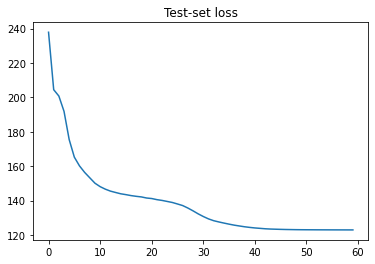

In [22]:
print(len(res_test_loss))
plt.plot(res_test_loss)
plt.title("Test-set loss")
plt.savefig("C:/Users/王欣哲/Desktop/codes/人工智能基础/问题1 棋盘识别/2.模型训练/test_loss_60.jpg")
plt.show()

保存训练模型

In [17]:
saver = tf.train.Saver()#为下面保存做准备
saver.save(sess, './net_2.0/conv_ver_1.ckpt')

'./net_2.0/conv_ver_1.ckpt'

从数据集抽取数据，检测训练情况

In [43]:
batch = get_test_batch(250)
sess.run(acc,feed_dict={xs:batch[0], ys: batch[1],keep_prob:1.0})

1.0

122.83965
1.0


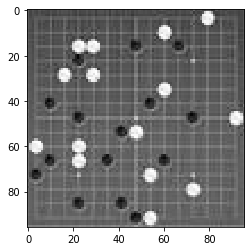

In [57]:
batch = get_train_batch(1)
infer_y1 = sess.run(y1,feed_dict={xs:batch[0], ys: batch[1]})
#infer_y2 = sess.run(y2,feed_dict={xs:batch[0], ys: batch[1]})
infer_y = sess.run(y,feed_dict={xs:batch[0], ys: batch[1],keep_prob:1.0})
print(sess.run(loss,feed_dict={xs:batch[0], ys: batch[1],keep_prob:1.0}))
print(sess.run(acc,feed_dict={xs:batch[0], ys: batch[1],keep_prob:1.0}))
plt.imshow(batch[0].reshape(96,96),cmap='Greys',interpolation='None')

0 2


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2], dtype=int64)

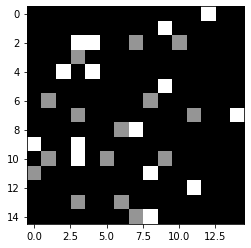

In [58]:
z = np.argmax(infer_y[0],1)
print(np.min(z),np.max(z))
plt.imshow(np.argmax(infer_y[0],1).reshape(15,15),cmap='Greys',interpolation='None')

(1, 48, 48, 8)


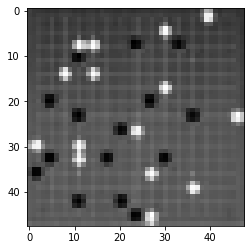

In [60]:
#内部卷积输出
print(infer_y1.shape)
plt.imshow(infer_y1[0,:,:,0],cmap='Greys',interpolation='None')